In [1]:
import time
import os
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datasetPlt as dataset
import cv2
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
%matplotlib inline

In [2]:
# Convolutional Layer 1.
filter_size1 = 5
num_filters1 = 16

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 32

# Convolutional Layer 4.
filter_size3 = 4
num_filters3 = 8

# Fully-connected layer.
fc_size = 128            

num_channels = 3
img_size = 64

img_size_flat = img_size * img_size * num_channels

img_shape = ( img_size, img_size)



#name of diseases
classes = ['Apple_Apple_scab',
           'Apple_Black_rot','Apple_healthy','Apple_Cedar_apple_rust','Blueberry_healthy','Cherry_healthy',
           'Cherry_Powdery_mildew','Corn_Cercospora_leaf_spot Gray_leaf_spot','Corn_Common_rust','Corn_Northern_Leaf_Blight',
           'Corn_healthy','Grape_Black_rot','Grape_Esca_(Black_Measles)','Grape_healthy','Grape_Leaf_blight',
           'Orange_Haunglongbing','Peach_Bacterial_spot','Pepper_bell_Bacterial_spot','Pepper_bell_healthy',
           'Peach_healthy','Potato_Early_blight','Potato_healthy','Potato_Late_blight','Raspberry_healthy',
           'Soybean_healthy','Squash_Powdery_mildew','Strawberry_healthy','Strawberry_Leaf_scorch',
           'Tomato_Bacterial_spot','Tomato_Tomato_Yellow_Leaf_Curl_Virus','Tomato_Tomato_mosaic_virus','Tomato_Target_Spot',
           'Tomato_Early_blight','Tomato_Spider_mites_Two-spotted_spider_mite','Tomato_Septoria_leaf_spot',
           'Tomato_Leaf_Mold','Tomato_Late_blight','Tomato_healthy']

num_classes = len(classes)

batch_size = 32


validation_size = .16

correct_sum = 0

early_stopping = None

train_path = 'train'
test_path = 'test'
print("done")

done


In [3]:
data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)
test_images, test_ids = dataset.read_test_set(test_path, img_size)


38
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Reading training images
Loading Apple_Apple_scab files (Index: 0)
Loading Apple_Black_rot files (Index: 1)
Loading Apple_healthy files (Index: 2)
Loading Apple_Cedar_apple_rust files (Index: 3)
Loading Blueberry_healthy files (Index: 4)
Loading Cherry_healthy files (Index: 5)
Loading Cherry_Powdery_mildew files (Index: 6)
Loading Corn_Cercospora_leaf_spot Gray_leaf_spot files (Index: 7)
Loading Corn_Common_rust files (Index: 8)
Loading Corn_Northern_Leaf_Blight files (Index: 9)
Loading Corn_healthy files (Index: 10)
Loading Grape_Black_rot files (Index: 11)
Loading Grape_Esca_(Black_Measles) files (Index: 12)
Loading Grape_healthy files (Index: 13)
Loading Grape_Leaf_blight files (Index: 14)
Loading Orange_Haunglongbing files (Index: 15)
Loading Peach_Bacterial_spot files (Index: 16)


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		6375
- Test-set:		0
- Validation-set:	1214


In [5]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
  
    plt.show()

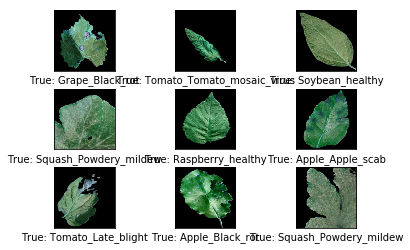

In [6]:


images, cls_true  = data.train.images, data.train.cls

plot_images(images=images, cls_true=cls_true)

In [7]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [8]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [9]:
def new_conv_layer(input,              
                   num_input_channels, 
                   filter_size,        
                   num_filters,        
                   use_pooling=True):

   
    shape = [filter_size, filter_size, num_input_channels, num_filters]

   
    weights = new_weights(shape=shape)

   
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases
    
    

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    
    
    


    return layer, weights

In [10]:
def flatten_layer(layer): 

    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [11]:
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,    
                 use_relu=True,
                 drop_out = True): 

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases
    if drop_out:
        layer = tf.nn.dropout(layer , 0.60)

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [12]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [13]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 16) dtype=float32>

In [14]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 16, 16, 32) dtype=float32>

In [15]:
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=False)
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 16, 16, 8) dtype=float32>

In [16]:
layer_flat, num_features = flatten_layer(layer_conv3)
layer_flat
num_features

2048

In [17]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         drop_out = True)
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

In [18]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         drop_out = False)
layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 38) dtype=float32>

In [19]:
y_pred = tf.nn.softmax(layer_fc2, name ="output")
y_pred_cls = tf.argmax(y_pred, axis=1, name = 'pred')
y_pred

<tf.Tensor 'output:0' shape=(?, 38) dtype=float32>

In [20]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-5).minimize(cost)

In [22]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
session = tf.Session()
#session run
session.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [24]:
tf.train.write_graph(session.graph_def,'.','model.pbtxt')

'.\\model.pbtxt'

In [25]:
train_batch_size = batch_size

In [26]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss, train_loss):
 

    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} - T_A: {1:>6.1%}, V_A: {2:>6.1%}, Validation Loss: {3:.3f}, train_loss : {4:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss, train_loss))
    return epoch + 1, acc, val_acc, val_loss

In [27]:

total_iterations = 0


def optimize(num_iterations):

    
    global total_iterations
    # time-usage
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations, total_iterations + num_iterations):

        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

    
        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

    
        #print( "{}  \100 ".format(i) ,end='\r')
        session.run(optimizer, feed_dict=feed_dict_train)

        if i%5 == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            train_loss = session.run(cost, feed_dict=feed_dict_train)
            
            epoch = total_iterations
          
            epoch, ta, va, vl = print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss, train_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break
            total_iterations += 1

    end_time = time.time()

    time_dif = end_time - start_time

    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [28]:
def plot_example_errors(cls_pred, correct):

    
    incorrect = (correct == False)
    
    
    images = data.valid.images[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = data.valid.cls[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [29]:
def plot_confusion_matrix(cls_pred):

    cls_true = data.valid.cls
    
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)

    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')


    
    plt.show()

In [30]:

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    
    num_test = len(data.valid.images)

    correct_sum = 0
    
    cls_pred = np.zeros(shape=num_test, dtype=np.int)


    i = 0

    while i < num_test:
        j = min(i + batch_size, num_test)
        
        images = data.valid.images[i:j, :].reshape(j-i, img_size_flat)
        
       # print(j-i)
    
        labels = data.valid.labels[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}
        
        
        
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j
        
    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    
    correct = (cls_true == cls_pred)

  
    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [31]:
print ( "start")
optimize(num_iterations=1) 
saver = tf.train.Saver()
saver.restore(session,'ckpt/model.ckpt')

start
Epoch 1 - T_A:   0.0%, V_A:   0.0%, Validation Loss: 3.647, train_loss : 3.647
Time elapsed: 0:00:01
INFO:tensorflow:Restoring parameters from ckpt/model.ckpt


In [32]:
print_test_accuracy()
optimize(num_iterations=20)

Accuracy on Test-Set: 67.5% (820 / 1214)
Epoch 2 - T_A:  53.1%, V_A:  62.5%, Validation Loss: 1.694, train_loss : 1.297
Epoch 3 - T_A:  71.9%, V_A:  40.6%, Validation Loss: 1.784, train_loss : 0.849
Epoch 4 - T_A:  62.5%, V_A:  62.5%, Validation Loss: 1.040, train_loss : 1.251
Epoch 5 - T_A:  81.2%, V_A:  75.0%, Validation Loss: 0.582, train_loss : 0.969
Time elapsed: 0:00:12


Accuracy on Test-Set: 67.7% (822 / 1214)
Confusion Matrix:


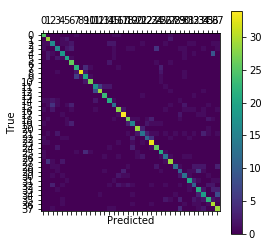

In [33]:
print_test_accuracy( show_confusion_matrix=True )

In [34]:
def plot_conv_weights( weights, name):

    
    w = session.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
       
        if i<num_filters:
    
            img = w[:, :, 0, i]

            
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    if not os.path.exists('conv_weight'):
        os.makedirs('conv_weight')
    plt.savefig('conv_weight/' + name + '.png')


    plt.show()

In [35]:
def plot_conv_layer(layer, image , name):
  

    image = image.reshape(img_size_flat)

    feed_dict = {x: [image]}

    values = session.run(layer, feed_dict=feed_dict)

    num_filters = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]

            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])
    if not os.path.exists('conv_layers'):
        os.makedirs('conv_layers')
    plt.savefig('conv_layers/' + name + '.png')
    plt.show()

In [36]:
def plot_image(image):
    plt.imshow(image.reshape(img_size, img_size, num_channels),
               interpolation='nearest')
    plt.show()

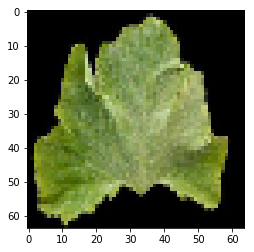

In [37]:
img1 = cv2.imread('test.jpg')
img1 = cv2.resize(img1, (img_size, img_size), cv2.INTER_LINEAR)
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img1)

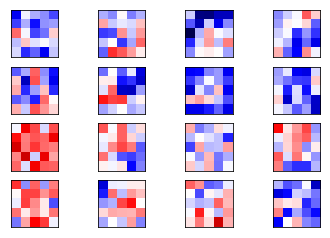

In [38]:
plot_conv_weights(weights=weights_conv1 , name = 'weights_conv1')

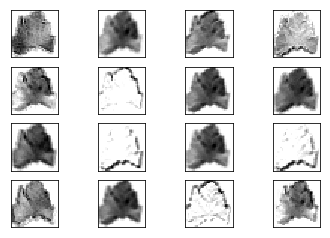

In [39]:
plot_conv_layer(layer=layer_conv1, image=img1 , name = "layer_conv1")

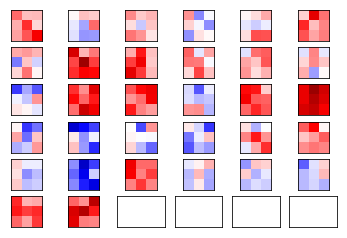

In [40]:
plot_conv_weights(weights=weights_conv2 , name = 'weights_conv2')

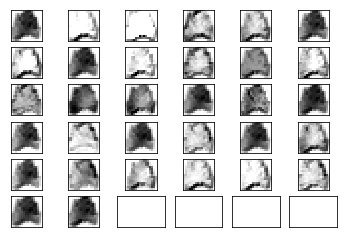

In [41]:
plot_conv_layer(layer=layer_conv2, image=img1 , name = 'layer_conv2')

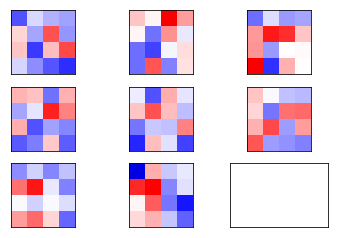

In [42]:
plot_conv_weights(weights=weights_conv3 , name = 'weights_conv3')

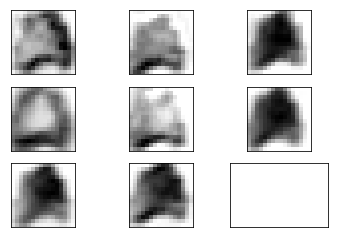

In [43]:
plot_conv_layer(layer=layer_conv3, image=img1 , name = 'layer_conv3')

# Now create pb file for model deployment in android

In [44]:
if not os.path.exists('out'):
        os.mkdir('out')

input_node_name = "x"
MODEL_NAME = "model"
output_node_name = "output"

In [45]:
saver.save(session, 'out/' + MODEL_NAME + '.chkp')

'out/model.chkp'

In [46]:
tf.train.write_graph(session.graph_def, 'out/',MODEL_NAME + '.pbtxt', True)

'out/model.pbtxt'

In [47]:
freeze_graph.freeze_graph('out/' + MODEL_NAME + '.pbtxt', None, False,
        'out/' + MODEL_NAME + '.chkp', output_node_name, "save/restore_all",
        "save/Const:0", 'out/frozen_' + MODEL_NAME + '.pb', True, "")

INFO:tensorflow:Restoring parameters from out/model.chkp
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


In [48]:
input_graph_def = tf.GraphDef()
with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
    input_graph_def.ParseFromString(f.read())

In [49]:
output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_name, [output_node_name],
            tf.float32.as_datatype_enum)

In [50]:
with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())
print("graph saved!")

graph saved!
